<a href="https://colab.research.google.com/github/andrelbourgeois/CASA0018/blob/main/simpleTFLite2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created Data


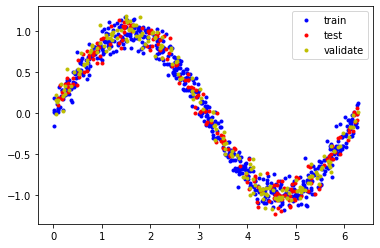


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                32        
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________

Epoch 1/500
12/12 [==============================] - 1s 18ms/step - loss: 0.7034 - mae: 0.7469 - val_loss: 0.6467 - val_mae: 0.7412
Epoch 2/500
12/12 [==============================] - 0s 5ms/step - loss: 0.4878 - mae: 0.6224 - val_loss: 0.5304 - val_mae: 0.6474
Epoch 3/500
12/12 [==============================] - 0s



7/7 [==============================] - 0s 3ms/step


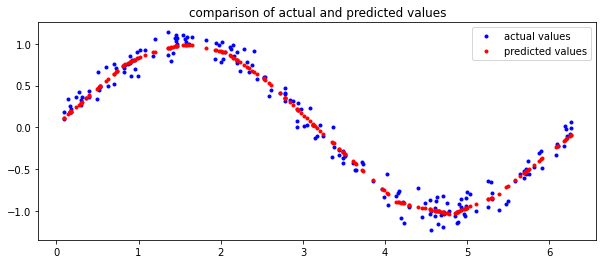

7/7 [==============================] - 0s 2ms/step


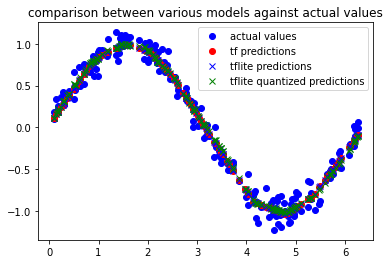

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,3232 bytes,(reduced by 864 bytes)
TensorFlow Lite Quantized,2736 bytes,(reduced by 496 bytes)


In [6]:
#this file is an improved version of simpleTFLite
#incorporating a redesigned and larger model

#define paths to model files
#are these file locations on the device???
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

#these files will have model saved to them
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR +'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'


#setup environment + import dependencies

#import tensorflow - open source machine learning library
import tensorflow as tf
#import keras - this is tensforflow's high level api for deep learning
from tensorflow import keras
#numpy is a math library
import numpy as np
#pandas is a data manipulation library
import pandas as pd
#matplotlib is a graphing library
import matplotlib.pyplot as plt
#math is python's math library
import math

#set seed for experiment reproducability
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

#---------------------------------------------------------------------------

#CREATE SOME DATA

#number of sample datapoints
SAMPLES = 1000

#generate a uniformly distributed set of random numbers in the range from
#0 to 2pi, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

#shuffle the values to guarentee they're not in order
np.random.shuffle(x_values)

#calculate the corresponding y values using a sine wave
y_values = np.sin(x_values).astype(np.float32)

#add noise
#add a small random number to y values, approximating something more life-like
y_values += 0.1 * np.random.randn(*y_values.shape)

#the following code will split the data into training (60%), validation (20%),
#and testing (20%) sets
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

#use np.split to chop data into three parts
#the second argument to np.split is an array of indicies where the data will be
#split - we provide two indices so the data will be divided into three chunks
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#double check that our splits add up correctly
assert (x_train.size + x_test.size + x_validate.size) == SAMPLES

#plot our data, the 'b.' argument tells the library to print blue dots, etc
#plot partitions in differenet colours
print('Created Data')
plt.plot(x_train, y_train, 'b.', label='train')
plt.plot(x_test, y_test, 'r.', label='test')
plt.plot(x_validate, y_validate, 'y.', label='validate')
plt.legend()
plt.show()
print()

#---------------------------------------------------------------------------

#DESIGN THE MODEL
#we'll use keras to create a simple model architecture
model = tf.keras.Sequential()

#first layer takes a scalar input and feeds it through 16 neurons
#these decide whether to activate based on the relu activation function
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

#additional second layer to learn more complex representation of sine function
model.add(keras.layers.Dense(16, activation='relu'))

#the final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

#compile the model using the standar adam optimizer and the
#mean squared error or mse loss function for regression and mean abs error

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
print()

#TRAIN THE MODEL
#use the data created to train the model that was designed
#this fit will run through the data 500 times (epochs) in groups (batches)
#of 50
history = model.fit(x_train, y_train, epochs=500, batch_size=50,
                        validation_data=(x_validate, y_validate))
#save the model to disc
model.save(MODEL_TF)

#------------------------------------------------------------------------

#PLOT METRICS

#loss (or mean squared error)
#draw a graph of the loss values, which is the distance between
#the predicted and actual values during the training and validation

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
print()

#skip the first few epochs so the graph is easier to read
SKIP = 200

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
print()

#mean absolute error
#draw a graph of the mean absolute error, which is another way of
#measuring the maout of error in the prediction

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='training mae')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='validation mae')
plt.title('training and validation mae')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend()

plt.tight_layout

#this example show consistently lower loss and mae values
#as well as better validation metrics than training
#this is an indication that the model is not overfitting

#calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

#make predictions based on the model
y_test_pred = model.predict(x_test)

#graph the actual and predicted values against each other
plt.clf()
plt.title('comparison of actual and predicted values')
plt.plot(x_test, y_test, 'b.', label='actual values')
plt.plot(x_test, y_test_pred, 'r.', label='predicted values')
plt.legend()
plt.show()

#CONVERT INTO TF LITE FORMAT
#convert the model to the tf lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()
#save model to disk
open(MODEL_NO_QUANT_TFLITE, 'wb').write(model_no_quant_tflite)

#convert the model to tf lite format with quantization
def representative_dataset_generator():
  for value in x_train:
    yield[np.array(value, dtype=np.float32, ndmin=2)]

#set the optimization flag - DEFAULT includes quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#enforce integer-only quantization to reduce model size
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

#provide a representative dataset to ensure we quantize correctly
converter.representative_dataset = representative_dataset_generator

model_tflite = converter.convert()

#save model to disc
open(MODEL_TFLITE, 'wb').write(model_tflite)

#COMPARE MODEL PERFORMANCE
def predict_tflite(tflite_model, x_test):
  #prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  #intitialize the tflite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  #if required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details['quantization']
  if(input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details['dtype'])

  #invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details['dtype'])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details['index'], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details['index'])[0]

  #if required, dequantize the output layer (from integer to float)
  output_scale, output_zero_point = output_details['quantization']
  if(output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) *output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

#calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

#compare predictions
plt.clf()
plt.title('comparison between various models against actual values')
plt.plot(x_test, y_test, 'bo', label='actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='tf predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='tflite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='tflite quantized predictions')
plt.legend()
plt.show()

#calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

#compare loss
df = pd.DataFrame.from_records(
    [['TensorFlow', loss_tf],
     ['TensorFlow Lite', loss_no_quant_tflite],
     ['TensorFlow Lite Quantized', loss_tflite]],
     columns = ['Model', 'Loss/MSE'], index='Model').round(4)
df

#calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}



# New Section

# New Section